In [1]:
import netCDF4 as nc
import pylab as py
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.cm as cm
import sys
import os
import errno
dirc=sys.argv

import logging
import time as ti
start = ti.time()


CO2         = 'echr0001'
num         = str(58)
no_of_days  = 30

current_dir = os.getcwd()
parts       = current_dir.split(os.sep)
quarter     = "/"+os.path.join(*parts[:5])

import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
        logging.debug('destination folder created !')
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            logging.debug('destination folder exists already!')
            raise

def get_data(variable, f):
        ncfile = f
        v_var  = nc.Dataset(ncfile,'r')
        data   = v_var.variables
        each_model_name = data[variable][:]
        v_var.close()
        return each_model_name
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


last=360

In [2]:
log_directory = quarter+'/codes/shell_scripts/convert_isentrope/log/test2/'
make_sure_path_exists( path   = log_directory )


for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

if CO2=='None':
     CO2 = 'echr0001'
exp_dir = 'ATM_dm_pl_'+CO2+'_10'

source = '/project2/tas1/ockham/data11/tas/echam-aiv_rcc_6.1.00p1/'+CO2+'/'
exp_dir = 'ATM_dm_pl_'+CO2+'_10'
one_year = source+exp_dir+num+'.nc'

pres_dir = 'ATM_dm_ml_'+CO2+'_10'
pres_one_year = source+pres_dir+num+'.nc'
ps       = get_data('aps', pres_one_year)[0:last]

def surface_pressure_correction(y):
        mask = (P[None,:,None,None]<ps[:, None, :,:])
        mask = mask.astype(float)
        mask[mask<1]= np.nan # 
        y_correct = y*mask
        return y_correct

make_sure_path_exists(source);

logging.basicConfig( filename = log_directory+'momentum'+exp_dir+num+'.log',level=logging.DEBUG, \
                     format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

destination = quarter+'/post_process_data/echam/data_in_isentropic_coord/'+exp_dir+num+'/test2/'
make_sure_path_exists(destination);

v_variables = nc.Dataset(one_year,'r')
v_var=v_variables.variables

logging.debug('....Extract ncfile save MSE and momentum fluxes and radiation....'+str(num)+' averaged over '+str(no_of_days))

logging.debug('imported nc file')


In [3]:
sigma= 5.670367e-8 ## Stefan's constant
Rd=286.9 # J/Kg
Rv=461.5 # J/kg
Cp= 1004.64 # J/kg/deg
G= 9.8
L=2.500e6 # J/kg
#mon=12

last = 360

lat=v_var['lat'][:]
lon=v_var['lon'][:]
P  =v_var['lev'][:]

In [25]:
logging.debug('imported coordinates')


if no_of_days == None:
   no_of_days = 30
else:
   days = int(no_of_days)

no_of_years = 360/(12*30)
no_of_months =12
hours = 1


# pres      = v_var['pres'][:last,...]*100
# logging.debug('imported pressure')


In [4]:
temp      = surface_pressure_correction(v_var['t'][:last,...]) ## (time, lev, lat, lon)
logging.debug('saved temp')


In [5]:
start = ti.time()
v_comp    = surface_pressure_correction(v_var['v'][:last,...])
logging.debug('saved v_comp')
end = ti.time()
print end-start

26.9811248779


In [10]:
start = ti.time()
u_comp    = surface_pressure_correction(v_var['u'][:last,...])
logging.debug('saved u_comp')
end = ti.time()
print end-start

19.5410239697


In [6]:
start=ti.time()
omega     = surface_pressure_correction(v_var['omega'][:last,...])
logging.debug('saved omega')
end=ti.time()
print (end-start)

26.3957371712


In [7]:
start=ti.time()
Z         = surface_pressure_correction(v_var['geopoth'][:last,...])
logging.debug('saved Z')
end=ti.time()
print (end-start)

17.4543340206


In [8]:
start=ti.time()
q         = surface_pressure_correction(v_var['q'][:last,...])  ### Specific humidity
logging.debug('saved q')
end=ti.time()
print (end-start)

18.8657560349


In [12]:
CpT       =  Cp*temp
Lq        =  L*q
gZ        =  G*Z

u_sq= u_comp**2
v_sq= v_comp**2
KE  = (u_sq+v_sq)/2.0

MSE       = (CpT+Lq+gZ+KE)

In [13]:
theta = temp*(100000/P[None,:,None,None])**0.286

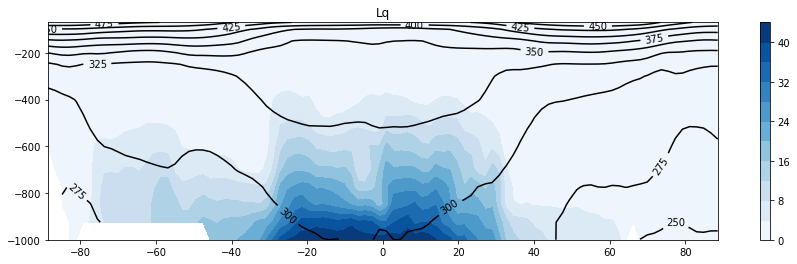

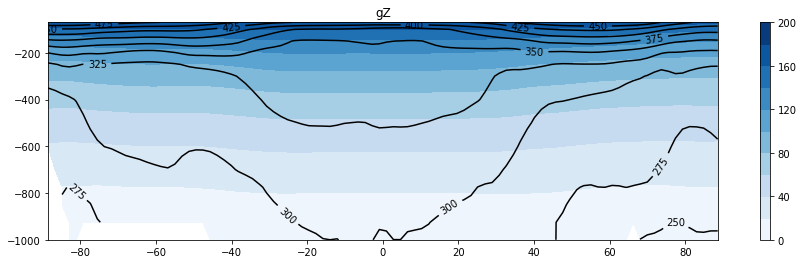

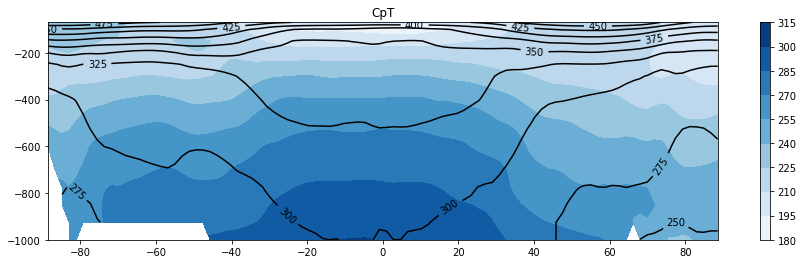

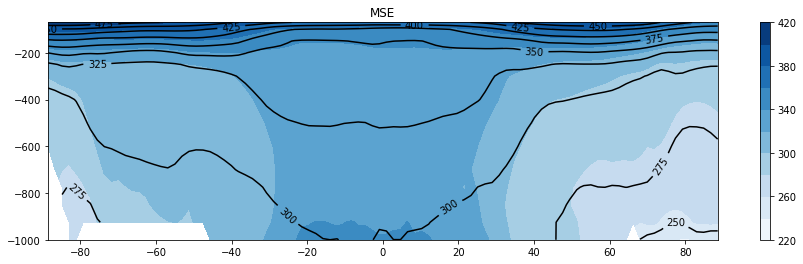

In [14]:
ra= np.arange(260,430,10)
pi=0; pf=-12

ra= np.arange(260,430,10)
py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100, Lq[0,pi:pf,:,100]/Cp, 10, cmap=cm.Blues); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, (theta[0,pi:pf,:,100])/1, 10, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.title('Lq')

ra= np.arange(260,430,10)
py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100, gZ[0,pi:pf,:,100]/Cp,10, cmap=cm.Blues); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, (theta[0,pi:pf,:,100])/1, 10, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.title('gZ')

ra= np.arange(260,430,10)
py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100, CpT[0,pi:pf,:,100]/Cp, 10,cmap=cm.Blues); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, (theta[0,pi:pf,:,100])/1, 10, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.title('CpT')

py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100, MSE[0,pi:pf,:,100]/Cp, 10, cmap=cm.Blues); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, (theta[0,pi:pf,:,100])/1, 10, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.title('MSE')
py.show()




/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


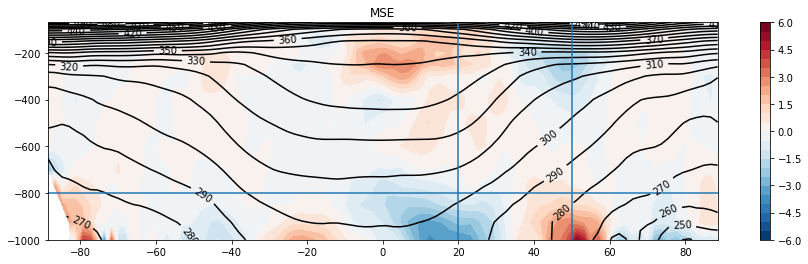

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: Mean of empty slice


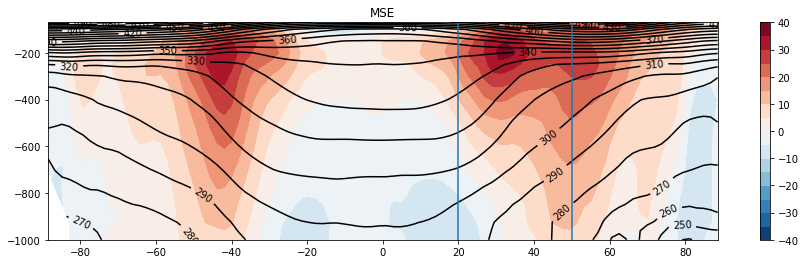

In [69]:
ra = np.arange(-6,6.5,0.5)
py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100,  np.nanmean(v_comp,axis=-1)[0,pi:pf,:], ra , cmap=cm.RdBu_r); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, np.nanmean(theta,axis=-1)[0,pi:pf,:], 25, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.title('MSE')
py.axvline(20)
py.axvline(50)
py.axhline(-800)
py.show()

ra = np.arange(-40,45,5)
py.figure(figsize=(15,4))
py.contourf(lat, -P[pi:pf]/100, np.nanmean(u_comp,axis=-1)[0,pi:pf,:], ra, cmap=cm.RdBu_r); py.colorbar()
c=py.contour(lat, -P[pi:pf]/100, np.nanmean(theta,axis=-1)[0,pi:pf,:], 25, colors='k'); 
py.clabel(c, fmt='%1d' , labelsize=20)
py.axvline(20)
py.axvline(50)
py.title('MSE')
py.show()


In [66]:
ind=((lat>19) & (lat<20))
lat[ind]

masked_array(data=[19.58521861],
             mask=False,
       fill_value=1e+20)

In [63]:
np.nanmean(theta,axis=-1)[0,pi:pf,ind]

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


masked_array(data=[[276.04309615, 276.26428125, 280.18761504,
                    284.37053499, 288.45040446, 293.79836099,
                    299.27828858, 304.44665448, 311.51063722,
                    319.23761674, 337.55356735, 373.3498899 ,
                    416.59891617, 457.70301832]],
             mask=False,
       fill_value=1e+20)

In [67]:
np.nanmean(theta,axis=-1)[0,pi:pf,ind]

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


masked_array(data=[[295.06152211, 296.40001157, 299.59666173,
                    303.7565363 , 309.5654961 , 316.42050665,
                    322.72624621, 328.84988026, 334.0597746 ,
                    336.87706619, 341.7933505 , 353.04220598,
                    378.10924671, 420.83395344]],
             mask=False,
       fill_value=1e+20)

In [15]:
logging.debug('calculated KE')

CpT       =  Cp*temp
Lq        =  L*q
gZ        =  G*Z
MSE       = (CpT+Lq+gZ+KE)

logging.debug('calculated MSE fluxes')

Pa = np.append(P,0)

rho_S = (Pa[:-1]-Pa[1:])/10.0
rho_s = rho_S[None,:,None,None]

def reshape(y):
    y1=y.reshape((no_of_years,no_of_months,days,hours,len(P),len(lat),len(lon)))
    return y1

def weighted(arg):
    w = arg*(rho_S)[None,None,None,None,:,None,None]
    return w

def R(y):
    y1 = reshape(y)
    return np.nanmean( np.nanmean( np.nanmean( np.nanmean(reshape(y1), axis=2), axis=2), axis=-1), axis=0)


In [16]:

logging.debug("loaded coordinates dictionary")

import scipy.integrate as integrate

def MSE_total(m,vv=v_comp):
    v=vv
    M         = reshape(m)                     # (year, month,days, hour, plev, lat, lon)
    V         = reshape(v)
    mean_v    = np.nansum(np.nanmean(weighted(V),axis=-1)[...,None,:,:,None], axis=-3)/(np.nansum(rho_S))
    flux      = weighted(V-mean_v)*(M)                # (year, month,days, hour, plev, lat, lon)
    monthly_f = np.nanmean(np.nanmean(flux,axis=2),axis=2) # (year, month, plev, lat, lon)
    zonal_f   = np.nanmean(monthly_f,axis=-1)        # (year, month, plev, lat)
    return np.nanmean(zonal_f,axis=0)


In [17]:
# weighted

In [18]:

def mean_meridional(m,vv=v_comp):
    v         = vv
    M         = reshape(m)                     # (year, month,days, hour, plev, lat, lon)
    V         = reshape(v)
    mean_v    = np.nansum(np.nanmean(weighted(V),axis=-1)[...,None,:,:,None], axis=-3)/(np.nansum(rho_S)) 
    monthly_m = np.nanmean(np.nanmean(M,axis=2),axis=2)  # (year, month, days, hour, plev, lat, lon)
    monthly_v = np.nanmean(np.nanmean(weighted(V-mean_v),axis=2),axis=2)  # (year, month, plev, lat, lon)
    zonal_m   = np.nanmean(monthly_m,axis=-1)        # (year, month, plev, lat)
    zonal_v   = np.nanmean(monthly_v,axis=-1)
    return np.nanmean(zonal_m*zonal_v, axis=0)
# MM_flux_v     =mean_meridional(MSE)

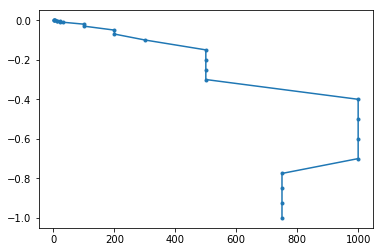

In [19]:
py.plot(rho_S,-(P)/10**5, '.-');
py.show()

In [20]:

def stationary_eddies(m,vv=v_comp):
    v         = vv
    M         = reshape(m)                              # (year, month, days, hour, plev, lat, lon)
    V         = reshape(v)
    monthly_m = np.nanmean(np.nanmean(M,axis=2),axis=2)           # (year, month,days, hour, plev, lat, lon)
    monthly_v = np.nanmean(np.nanmean(weighted(V),axis=2),axis=2)                        # (year, month, plev, lat, lon)
    m_star    = monthly_m-np.nanmean(monthly_m,axis=-1)[...,None]          # (year, month, plev, lat, lon)
    v_star    = monthly_v-np.nanmean(monthly_v,axis=-1)[...,None]
    flux_weighted  = ((m_star*v_star)[:,:,None,None,:,:,:])    # (year, month, plev, lat)
    return np.nanmean(np.nanmean(np.nanmean(np.nanmean(flux_weighted,axis=2),axis=2),axis=-1),axis=0)




In [21]:

def transient_eddies(m,vv=v_comp):
    v         = vv
    M         = reshape(m)                            # (year, month,days, hour, plev, lat, lon)
    V         = reshape(v)
    monthly_m = np.nanmean(np.nanmean(M,axis=2),axis=2)           # average over days 
    monthly_v = np.nanmean(np.nanmean((V),axis=2),axis=2)           # (month, plev, lat, lon)
    m_prime   = M-monthly_m[:,:,None,None,:,:,:]      # (month, days, plev, lat, lon)
    v_prime   = V-monthly_v[:,:,None,None,:,:,:]
    flux      = np.nanmean(np.nanmean(np.nanmean(weighted(m_prime*v_prime),axis=2),axis=2),axis=-1) # (year,month,plev,lat) 
    return np.nanmean(flux,axis=0)


logging.debug("defined functions")



In [ ]:
py.figure(1)
py.plot(lat, np.nanmean(PWv(TE_flux_v),axis=1)[0,:],'r-')
py.plot(lat, np.nanmean(PWv(SE_flux_v),axis=1)[0,:],'b-')
py.plot(lat, np.nanmean(( PWv(TE_flux_v) + PWv(TE_flux_v) +  PWv(MM_flux_v)  ),axis=1)[0,:],'m-')
py.plot(lat, np.nanmean(PWv(MM_flux_v),axis=1)[0,:],'g.-')
# py.plot(lat, np.nanmean(PWv(MM_KE_v),axis=1)[0,:],'k-')
py.show()

In [24]:
# no_of_years=1
# #############################
# ########   dm_by_dt    ######
# #############################

# def tendency_24_hours(h):
#     dt=24*60*60
#     d_by_dt=np.gradient(h,dt,axis=0)
#     return d_by_dt

# moist_enthalpy  = CpT+Lq+KE   ## ((1440, 29, 64, 128))
# dh_by_dt    = R(tendency_24_hours(rho_s*moist_enthalpy))
# dm_by_dt    = R(tendency_24_hours(rho_s*MSE))

# dgZ_by_dt_term_m1  = R(rho_s*tendency_24_hours(gZ))
# dgZ_by_dt_term2    = R(rho_s*deltheta_delt*dgZ_dtheta)

# dgZ_by_dt_term_h1  = -R(gZ*tendency_24_hours(rho_s))




In [26]:
######## v direction #######
start=ti.time()

def sm(y,n=20):
    return np.apply_along_axis(smooth, -1, y,n )

mse_flux_v    = sm(MSE_total(MSE))

MM_flux_v     = sm(mean_meridional(MSE))
SE_flux_v     =stationary_eddies(MSE)
TE_flux_v     =transient_eddies(MSE)

end=ti.time()
print (end-start)

logging.debug("Total fluxes v")


/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice


54.4617159367


In [27]:
start=ti.time()
TE_sensible_v=transient_eddies(CpT)
TE_moist_v   =transient_eddies(Lq)
TE_pot_v     =transient_eddies(gZ)
TE_KE_v      =transient_eddies(KE)
end=ti.time()
print (end-start)

logging.debug("TE fluxes v")


/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice


63.2872619629


In [28]:
start=ti.time()
SE_sensible_v=stationary_eddies(CpT)
SE_moist_v   =stationary_eddies(Lq)
SE_pot_v     =stationary_eddies(gZ)
SE_KE_v      =stationary_eddies(KE)
end=ti.time()
print (end-start)
logging.debug("SE fluxes v")


/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice


38.9590079784


In [29]:
start=ti.time()

MM_sensible_v= sm(mean_meridional(CpT))
MM_moist_v   = sm(mean_meridional(Lq))
MM_pot_v     = sm(mean_meridional(gZ))
MM_KE_v      = sm(mean_meridional(KE))
end=ti.time()
print (end-start)

logging.debug("MM fluxes v")


/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice


52.8387858868


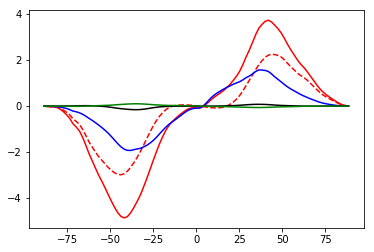

In [30]:
radius= 6371e3
def PWv(x):
    return x*2*np.pi*radius*np.cos(np.deg2rad(lat[None,None,None,:,]))/10**15

def PWv(x):
    return np.nansum(x,axis=-2)*2*np.pi*(radius)*np.cos(np.deg2rad(lat[None,None,:]))/10**15

py.figure(1)
py.plot(lat, np.nanmean(PWv(TE_flux_v),axis=1)[0,:],'r-')
py.plot(lat, np.nanmean(PWv(TE_sensible_v),axis=1)[0,:],'r--')
py.plot(lat, np.nanmean(PWv(TE_moist_v),axis=1)[0,:],'b-')
py.plot(lat, np.nanmean(PWv(TE_KE_v),axis=1)[0,:],'k-')
py.plot(lat, np.nanmean(PWv(TE_pot_v),axis=1)[0,:],'g-')
py.show()

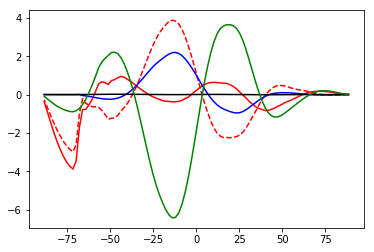

In [31]:
py.plot(lat, np.nanmean(PWv(MM_flux_v),axis=1)[0,:],'r-')
py.plot(lat, np.nanmean(PWv(MM_sensible_v),axis=1)[0,:],'r--')
py.plot(lat, np.nanmean(PWv(MM_moist_v),axis=1)[0,:],'b-')
py.plot(lat, np.nanmean(PWv(MM_KE_v),axis=1)[0,:],'k-')
py.plot(lat, np.nanmean(PWv(MM_pot_v),axis=1)[0,:],'g-')
py.show()

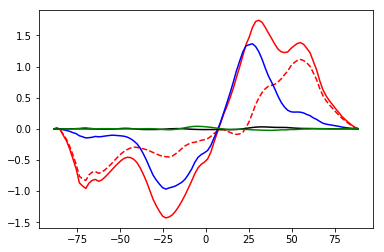

In [32]:
py.plot(lat, np.nanmean(PWv(SE_flux_v),axis=1)[0,:],'r-')
py.plot(lat, np.nanmean(PWv(SE_sensible_v),axis=1)[0,:],'r--')
py.plot(lat, np.nanmean(PWv(SE_moist_v),axis=1)[0,:],'b-')
py.plot(lat, np.nanmean(PWv(SE_KE_v),axis=1)[0,:],'k-')
py.plot(lat, np.nanmean(PWv(SE_pot_v),axis=1)[0,:],'g-')
py.show()

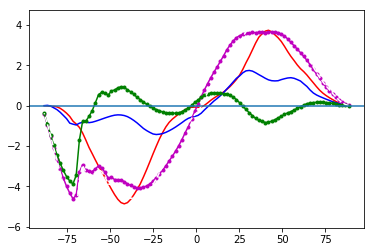

In [33]:
py.figure(1)
py.plot(lat, np.nanmean(PWv(TE_flux_v),axis=1)[0,:],'r-')
py.plot(lat, np.nanmean(PWv(SE_flux_v),axis=1)[0,:],'b-')
py.plot(lat, np.nanmean(PWv(mse_flux_v),axis=1)[0,:],'m.-')
py.plot(lat, np.nanmean(PWv(MM_flux_v),axis=1)[0,:],'g.-')
py.plot(lat, np.nanmean(PWv(MM_flux_v)+PWv(SE_flux_v)+PWv(TE_flux_v),axis=1)[0,:],'w--')
py.axhline(0)

# py.plot(lat, np.nanmean(PWv(mse_flux_v)-(PWv(MM_flux_v + SE_flux_v + TE_flux_v)),axis=1)[0,:],'m--')
py.show()

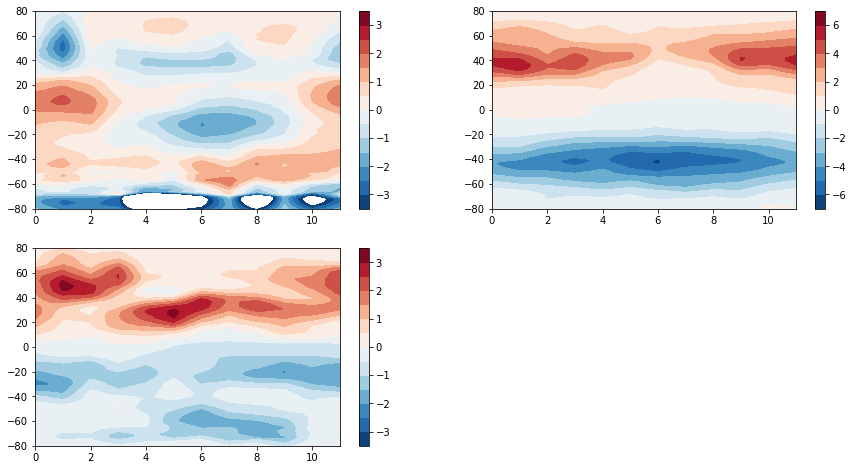

In [34]:
py.figure(figsize=(15,8))

py.subplot(2,2,1)
py.contourf(range(12), lat, PWv(MM_flux_v)[0,...].T, np.arange(-3.5,4.0,0.5), cmap=cm.RdBu_r); py.colorbar()
py.ylim(-80,80)

py.subplot(2,2,3)
py.contourf(range(12), lat, PWv(SE_flux_v)[0,...].T, np.arange(-3.5,4.0,0.5), cmap=cm.RdBu_r); py.colorbar()
py.ylim(-80,80)

py.subplot(2,2,2)
py.contourf(range(12), lat, PWv(TE_flux_v)[0,...].T, np.arange(-7,8.0,1.0), cmap=cm.RdBu_r); py.colorbar()
py.ylim(-80,80)

py.show()

In [36]:
mean_v =  np.nansum( weighted(reshape(v_comp))[...,None,:,:,:], axis=-3)/(np.nansum(rho_S)) 

In [37]:
np.squeeze(mean_v).shape

(12, 30, 96, 192)

In [38]:
np.nanmean(np.squeeze(mean_v),axis=-1).shape

(12, 30, 96)

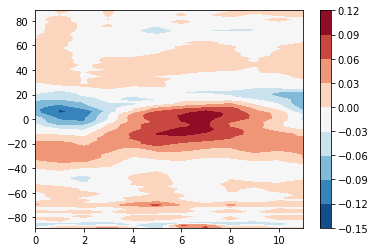

In [39]:
py.contourf(range(12), lat, np.nanmean(np.nanmean(np.squeeze(mean_v),axis=-1),axis=1).T, cmap=cm.RdBu_r); py.colorbar()
py.show()

In [63]:
rho_S = (Pa[:-1]-Pa[1:])/9.8
rho_s = rho_S[None,:,None,None]

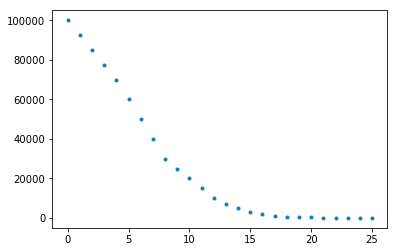

In [61]:
py.plot(P,'.')
py.show()

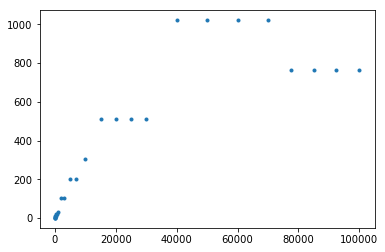

In [65]:
py.plot(P, rho_s.squeeze(),'.')
py.show()